# 2019 12 17
## Testing rpa senders 
This experiment was performed to try out 1D signal transmission thru a single line of pulsers.
Rpa-inducible Cin AHL senders.
Initial OD was ~0.1 for pulsers and ~0.7 for senders, measured by the nanodrop.
37C
IPTG 1.5mM
Rhl AHL 50nM



In [1]:
import os
import sys
import time
import datetime
import re
import multiprocessing
import ast

import numpy as np
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}

sns.set(rc=rc)

from scipy import ndimage as ndi
import scipy as scp
import pandas as pd

import matplotlib.animation as anm
from IPython.display import HTML

from skimage.external.tifffile import TiffWriter

from PIL import Image

import skimage.filters
import skimage.io
import skimage.morphology
import skimage.feature
import skimage.exposure

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh import palettes, transform

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 24, 
      'xtick.labelsize': 18, 
      'ytick.labelsize': 18, 
      'legend.fontsize': 18,
      'axes.facecolor': 'fbfbfc'}
sns.set_context('talk', rc=rc)

%load_ext line_profiler

%matplotlib inline
output_notebook()

# you need to populate image lists from the two folders

# file_temp = "/mnt/disks/movie-181208/180827_1/{}/img_{:09d}_{}_000.tif"

Loading BokehJS ...

In [2]:
# Channel information for IX81 inverted microscope
all_channel_inds = [str(xx) for xx in range(6)]
all_channel_names = ['Brightfield', 'GFP', 'YFP', 'mScarlet', 'unk', 'sfCFP']
all_channel_dict = dict(zip(all_channel_inds, all_channel_names))

def img_metadata_dict(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        This function uses string replacements to read dictionary key-value pairs.
    
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    return dict(zip(metadata_keys, metadata_vals))

def img_metadata_dict_full(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        After some cleanup, this function reads the metadata string directly as a dictionary definition.
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    in_str = metadata_str[9:].replace('\n','').replace('\s*','').replace('null','None').replace('false','False').replace('true','True')
    out_dict = ast.literal_eval(in_str)
    return out_dict

def img_metadata(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata = img_metadata_dict(img)
    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple), metadata["Channel"]

def fn_metadata(fn):
    '''Wrapper for reading creation time from an image filename'''
    with Image.open(fn) as img:
        out = img_metadata(img)
    return out

def fn_metadata_full(fn):
    '''Wrapper for reading full metadata dictionary from a filename'''
    with Image.open(fn) as img:
        out = img_metadata_dict_full(img)
    return out

def get_time_vector_from_fn(fn):
    time_dict = dict(zip(channel,len(channel)*[]))
    with Image.open(fn) as img:
        try:
            while 1:
                ct, ch = img_metadata(img)
                time_dict[chan_dict[ch]].append(ct)
                img.seek(img.tell()+1)
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
    return time_dict

def get_data_from_frame(img):
    ct, ch = img_metadata(img)
    im_arr = np.array(list(img.getdata()),dtype=np.uint16).reshape(img.size[::-1])
    return ct, ch, im_arr

def get_movie_from_img(img):
    img_dict = dict(zip(channel,len(channel)*[]))
    time_dict = dict(zip(channel,len(channel)*[]))
    try:
        img.seek(0)
        while 1:
            ct, ch, im_arr = get_data_from_frame(img)
            ch = chan_dict[ch]
            img_dict[ch].append(im_arr)
            time_dict[ch].append(ct)
            img.seek(img.tell()+1)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    for key in img_dict:
        h, w = im_arr.shape
        img_dict[key] = np.vstack([x.reshape((1, h, w, 1)) for x in img_dict[key]])
    return img_dict, time_dict

def read_img(fn):
    with Image.open(fn) as img:
        return get_movie_from_img(img)
        
def concat_img_files(fn_list, fn_out):
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    with TiffWriter(fn_out, bigtiff=True) as tif:
        for fn in fn_list:
            eof_flag = True
            print("Writing ", fn)
            with Image.open(fn) as img:
                while eof_flag:
                    _, _, im_arr = get_data_from_frame(img)
                    img_md = img_metadata_dict(img)
                    for k in keep_keys:
                        metadata[k] = img_md[k]
                    metadata['Frame'] = int(os.path.basename(fn).split("_")[1])
                    h, w = im_arr.shape
                    tif.save(im_arr, metadata=metadata.copy())
                    try:
                        i += 1
                        img.seek(img.tell()+1)
                    except:
                        eof_flag = False
        
def convert_img_file(fn, fn_out):
    dirname = os.path.dirname(fn)
    fn_out = os.path.join(dirname, fn_out)
    ct = datetime.datetime.fromtimestamp(ctime(fn))
    eof_flag = True
    with Image.open(fn) as img:
        with TiffWriter(fn_out, bigtiff=True) as tif:
            while eof_flag:
                _, _, im_arr = get_data_from_frame(img)
                metadata = img_metadata_dict(img)
                tif.save(im_arr, datetime=ct, metadata=metadata)
                try:
                    img.seek(img.tell()+1)
                except:
                    eof_flag = False
    
def process_file(fn, skip=0):
    with Image.open(fn) as img:
        eof_flag = True
        column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
        df = pd.DataFrame(columns = column_names)
        try:
            while eof_flag:
                acq_dict = {}
                for i in range(3):
                    ct, ch, im_arr = get_data_from_frame(img)
#                     ch = chan_dict[ch]
                    acq_dict[ch] = (ct, im_arr)
                    try:
                        img.seek(img.tell()+1)
                    except EOFError:
                        eof_flag = False
                rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
                for col_i in range(num):
                    df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                    df = df.append(pd.DataFrame(df_dict), ignore_index=True)
                try:
                    img.seek(img.tell()+3*skip)
                except EOFError:
                    eof_flag = False
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
        df.to_csv(fn+".csv")
    return df

    
def process_file_skimage(fn):
    time_vec = get_time_vector_from_fn(fn)['"Brightfield"']
    im = skimage.io.imread(fn)
    column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns = column_names)
    try:
        while eof_flag:
            acq_dict = {}
            for i in range(3):
                ct, ch, im_arr = get_data_from_frame(img)
                acq_dict[ch] = (ct, im_arr)
                try:
                    img.seek(img.tell()+1)
                except EOFError:
                    eof_flag = False
            rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
            for col_i in range(num):
                df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    except KeyError:
        pass
    df.to_csv(fn+".csv")
    return df

def ctime(fname):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    with Image.open(fname) as img:
        metadata_str = img.tag_v2[50839].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    metadata = dict(zip(metadata_keys, metadata_vals))

    time_tuple = time.strptime(metadata['Time'][:-6],r"%Y-%m-%d %H:%M:%S")
    return time.mktime(time_tuple)

def crop(img):
    w, h = img.shape
    if w > 1000:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    return(img[y1:y2,x1:x2])

def uncrop(img):
    w, h = img.shape
    if w > 800:
        out_img = np.zeros((512*2, 672*2))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        out_img = np.zeros((512, 672))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    out_img[y1:y2,x1:x2] = img
    return(out_img)

def label_image(im_arr):
    im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
    w, h = im_arr.shape

    # Convert the uneven image to floating point
    im_float = im_arr
    # Smooth to reduce noise
    g_radius = 5
    im_smooth = skimage.filters.gaussian(im_float, g_radius)
    im_bgsub = im_float - im_smooth

    # Perform the median filter
    selem = skimage.morphology.square(4)
    im_bgsub = skimage.filters.median(im_bgsub, selem) / 4096.0
    
    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

    # Edge detection
    im_edge = skimage.filters.sobel(im_adj)
    im_edge = skimage.exposure.equalize_adapthist(im_adj)

    # Remove small objects and fill holes
    if np.all(im_edge == im_edge[0,0]) or np.any(np.isnan(im_edge)):
        return np.zeros((w,h)), 1
    thresh = skimage.filters.threshold_otsu(im_edge)
    selem = skimage.morphology.square(2)
    im_bw = skimage.morphology.binary_dilation(im_edge > thresh, selem)
    selem = skimage.morphology.square(12)
    im_bw = skimage.morphology.binary_closing(im_bw, selem)
    
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=10)
    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def get_fluors(bfi, rfp, gfp):
    im_labeled, num = label_image_2(bfi)
    num  = im_labeled.max()
#     rfp, gfp = [crop(x) for x in [rfp, gfp]]
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    gfp_bg = np.mean(gfp[im_labeled == 0])
    rfp_bg = np.mean(rfp[im_labeled == 0])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def read_tiff_file(fn, skip=0):
    print("Begin " + fn)
    df = process_file(fn, skip=skip)
    df.to_csv(fn+".csv", index=False)
    print("Finished " + fn)

def par_worker(fn_list, skip=1):
    for fn in fn_list:
        read_tiff_file(fn, skip=skip)
    

In [3]:
super_dir = '../img_1'
pos_dirs = [os.path.join(super_dir, xx) for xx in os.listdir(super_dir) if os.path.isdir(os.path.join(super_dir, xx))]
img_files = [os.path.join(pos_dir, xx) for pos_dir in pos_dirs for xx in os.listdir(pos_dir) if '.tif' in xx]
time_vec = np.array([ctime(xx) for xx in img_files])
time_vec = time_vec - time_vec.min()
np.save('timevec',time_vec)

In [4]:
# Extract movie metadata
all_metadata = fn_metadata_full(img_files[0])
summ_dict = all_metadata['Summary']
chan_ind = summ_dict['ChNames']
chan_int = [int(xx) for xx in chan_ind]
n_chan = len(chan_ind)
chan_int_dict = dict(zip(chan_int, np.arange(n_chan)))
chan_name = [all_channel_dict[xx] for xx in chan_ind]
n_pos = len(pos_dirs)#summ_dict['Positions']
im_width = summ_dict['Width']
im_height = summ_dict['Height']

In [5]:
img_files[0]

'../img_1/Pos5/img_000000025_3_000.tif'

In [6]:
img_re_pattern = r'{}/Pos(?P<pad>[0-9]+)/img_(?P<frame>[0-9]*)_(?P<channel>[0-9]*)_000.tif'.format(super_dir)
rem = re.findall(img_re_pattern, '\n'.join(img_files), re.MULTILINE)
rem_arr = np.array(rem)
rem_arr[rem_arr==''] = -1
metadata_arr = rem_arr.astype(np.int)
n_rows = metadata_arr.shape[0]
pad_vec, frame_vec, channel_vec = metadata_arr.T
# padpos_vec = padpos_vec1 + padpos_vec2
pad_vec = pad_vec - np.min(pad_vec)
time_vec = np.load('timevec.npy')
pos_vec = np.empty(n_rows,dtype=np.int)
# padpos_vec = np.empty(n_rows,dtype=np.int)

In [7]:
n_frames = np.max(frame_vec)+1

columns = ['pos','pad','frame','channel','fn','time']
col_data = [pos_vec, pad_vec, frame_vec, channel_vec, img_files, time_vec]
n_rows = len(img_files)
n_pads = len(np.unique(pad_vec))

# files_df = pd.read_csv('filesdf.csv')

files_df = pd.DataFrame(
    dict(zip(columns, col_data)))
files_df = files_df.sort_values(by='time')
files_df = files_df.loc[files_df.frame<n_frames,:]
gb_pp = files_df.groupby('pad')
for i, inds in enumerate(gb_pp.groups.values()):
    files_df.loc[inds,'pos'] = i
# gb_pp = files_df.groupby(['pad','pos'])
# for i, inds in enumerate(gb_pp.groups.values()):
#     files_df.loc[inds,'padpos'] = i
# files_df.loc[:,'pos'] = np.tile(np.repeat(np.arange(n_pos), n_chan), n_frames)

# def pad_helper_fn(pos):
#     pad_lims = np.array([8,19,32,44,56])
#     pad_inds = np.arange(len(pad_lims))
#     return np.min(pad_inds[pad_lims > pos])

# files_df.loc[:,'pad'] = np.array([pad_helper_fn(xx) for xx in files_df.pos.values])

pos_df = files_df.loc[:,['pos','pad']].groupby('pos').agg(np.min)
files_df.to_csv('filesdf.csv',index=False)

In [8]:
files_df = pd.read_csv('filesdf.csv')
gb_frame = files_df.groupby('frame')
sub_len = np.array([xx[1].shape[0] for xx in gb_frame])
frames = np.array([xx for xx in gb_frame.groups])

max_frame = frames[1:][np.diff(sub_len)==0].max()
files_df = files_df.loc[files_df.frame<=max_frame,:]

n_pads = len(np.unique(files_df.pad))
n_frames = np.max(files_df.frame)+1
pos_df = files_df.loc[:,['pos','pad']].groupby('pos').agg(np.min)

In [9]:
label_vec = [xx['Label'] for xx in summ_dict['InitialPositionList']]
xy_vec = [xx['DeviceCoordinatesUm']['XYStage'] for xx in summ_dict['InitialPositionList']]
lab_xy_dict = dict(zip(label_vec, xy_vec))
# [xx.split('/')[2] for xx in tmp_df.fn]

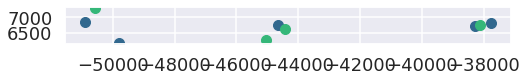

In [10]:
label_vec = [xx['Label'] for xx in summ_dict['InitialPositionList']]
xy_vec = [xx['DeviceCoordinatesUm']['XYStage'] for xx in summ_dict['InitialPositionList']]
label_xy_dict = dict(zip(label_vec, xy_vec))
pos_file_df = files_df.groupby('pos').agg(np.min)
# Cor_pos_df is corrected position DF. In this notebook, correcting the position is not
# necessary as there are only two imaging positions per pad. DF also includes inducer info
# 0, 1, 2 for inducers blank, C, R; respectively
columns = ['x','y','label','pad', 'dist']
n_cols = len(columns)
cor_pos_df = pd.DataFrame(np.empty((n_pos,n_cols)), columns=columns, index=np.arange(n_pos))
for pos in np.arange(n_pos):
    label = pos_file_df.loc[pos,'fn'].split('/')[2]
    x, y = label_xy_dict[label]
    pad = pos_df.loc[pos,'pad']
    cor_pos_df.loc[pos,['x', 'y', 'label', 'pad']] = [x, y, label, pad]
#     files_df.loc[files_df.pos==p_i,'x'] = x
#     files_df.loc[files_df.pos==p_i,'y'] = y

# cor_pos_df.sort_values(by=['pad','padpos'], inplace=True)
    
for p_i in np.arange(n_pos):
    pad = cor_pos_df.loc[p_i,['pad']].values[0]
    pad_xy = cor_pos_df.loc[(cor_pos_df.pad==pad),['x','y']].iloc[0,:].values
    pos_xy = cor_pos_df.loc[p_i,['x','y']].values
    dist = np.sqrt(np.power(pad_xy - pos_xy,2).sum())
    cor_pos_df.loc[p_i, 'dist'] = dist
    
def dist_f(pad_ind):
    '''
    Calculates distance between colonies for input pad index
    '''
    pos_arr = cor_pos_df.loc[cor_pos_df.pad == 3, ['x', 'y']].values
    dist = np.sqrt(np.sum(np.power(np.diff(pos_arr, axis=0),2)))
    return dist
    
plt.figure(figsize=(8,8))
for p_i in np.arange(n_pos):
    colors = sns.color_palette('viridis', n_colors=2)
    point_color = colors[np.int(np.mod(cor_pos_df.loc[p_i,"pad"],2))]
    plt.plot(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
             '.', 
             label=cor_pos_df.label[p_i],
             ms=20,
             c=colors[np.mod(p_i,2)])
plt.gca().set_aspect('equal')
plt.show()
# plt.legend()

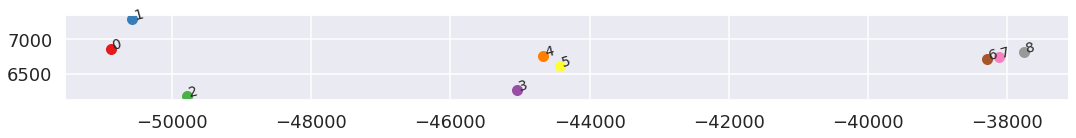

In [11]:
# n_pads=5
plt.figure(figsize=(18,18))
for p_i in np.arange(n_pos):
    colors = sns.color_palette('Set1', n_colors=n_pads)
    point_color = colors[np.int(cor_pos_df.loc[p_i,"pad"])]
    plt.plot(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
             '.', 
             label=cor_pos_df.pad[p_i],
             ms=20,
             c=point_color)
    plt.text(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
#              '{}'.format(np.int(cor_pos_df.padpos[p_i])),
#              '{}'.format(pos_file_df.loc[p_i,'fn'].split('/')[2]),
             '{}'.format(p_i),
             fontsize=14,
             rotation=15)

plt.gca().set_aspect('equal')

In [52]:
import matplotlib.animation as anm
from IPython.display import HTML

def write_movie(scale=4, pad_ind=3, skip=5):
    h, w = im_height//scale, im_width//scale
    pixels_per_um = 1/(1.6*1.6*scale)
    pad_df = cor_pos_df.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    fig_h, fig_w = np.array([h, w])/(250/scale)
    pad_arr = np.zeros((h, w, 3))
    img_arr = np.zeros((h, w, 3))
    bfp_norm = mpl_colors.Normalize(2e2, 6e4,clip=True)
    rfp_norm = mpl_colors.Normalize(0, 3e2,clip=True)
    cfp_norm = mpl_colors.Normalize(0, 3e2,clip=True)
    chan_vec = [0,3,5]
    norm_vec = [bfp_norm, rfp_norm, cfp_norm]

    def load_img(frame, pos, channel, rotation=180, scale=scale, sigma=3):
        fn = files_df.loc[(files_df.frame==frame)&(files_df.pos==pos)&(files_df.channel==channel),'fn'].values[0]
        img = skimage.filters.gaussian(skimage.io.imread(fn).astype(np.float), sigma)
        img = skimage.transform.downscale_local_mean(img, (scale, scale))
        return skimage.transform.rotate(img, rotation)

    def get_frame_arr(frame_ind):
        im_arr = np.zeros((h,w))
        for chan_i, channel in enumerate(chan_vec):
            for pos in pos_list:
                im_arr[:] = 0
                im_arr = load_img(frame_ind, pos, channel)
                pad_arr[:,:,chan_i] += im_arr


    fig, ax = plt.subplots(1, 1, figsize=(fig_w,fig_h+1.2))
    im = ax.imshow(pad_arr, animated=True, interpolation='none')
    #     cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Pad {}".format(pad_ind))
                
    def animate(i):
        pad_arr[:] = 0
        get_frame_arr(i)
        img_arr[:,:,0] = rfp_norm(pad_arr[:,:,1]) + 0.25*bfp_norm(pad_arr[:,:,0])
        img_arr[:,:,1] = 0.25*bfp_norm(pad_arr[:,:,0]) + 0.75*cfp_norm(pad_arr[:,:,2])
        img_arr[:,:,2] = 0.75*cfp_norm(pad_arr[:,:,2])+ 0.25*bfp_norm(pad_arr[:,:,0])
        im.set_array(img_arr)

    fig.tight_layout()

    anim = anm.FuncAnimation(fig, animate, interval=100, frames=np.arange(0,n_frames,skip))


    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())    

for pad_ind in np.arange(n_pads)[::-1]:
    anim = write_movie(scale=4, pad_ind=pad_ind,skip=1)
    anim.save('190726_pad{}.gif'.format(pad_ind), dpi=80, fps=15, writer='pillow')


In [58]:
import matplotlib.animation as anm
from IPython.display import HTML

def write_tiff(fn_out, scale=4, pad_ind=3, skip=5):
    h, w = im_height//scale, im_width//scale
    pixels_per_um = 1/(1.6*1.6*scale)
    pad_df = cor_pos_df.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    pad_arr = np.zeros((h, w, 3))
    chan_vec = [0,3,5]
    
    def load_img(frame, pos, channel, rotation=180, scale=scale, sigma=3):
        fn = files_df.loc[(files_df.frame==frame)&(files_df.pos==pos)&(files_df.channel==channel),'fn'].values[0]
        img = skimage.io.imread(fn)
        img = skimage.transform.downscale_local_mean(img, (scale, scale))
        return skimage.transform.rotate(img, rotation)

    def get_frame_arr(frame_ind):
        im_arr = np.zeros((h,w))
        for chan_i, channel in enumerate(chan_vec):
            for pos in pos_list:
                im_arr[:] = 0
                im_arr = load_img(frame_ind, pos, channel)
                pad_arr[:,:,chan_i] += im_arr

    def animate(i, pad_arr):
        pad_arr[:] = 0
        get_frame_arr(i)
        return pad_arr

    with TiffWriter(fn_out, bigtiff=True, imagej=True) as tif:
        for i in np.arange(0,n_frames,skip):#n_frames):
            pad_arr = animate(i, pad_arr)
            for j in np.arange(3):
                tif.save((pad_arr[:,:,j]).astype(np.uint16).reshape((1,h,w)))

for pad_ind in np.arange(n_pads):
    fn_out = '190726_pad{}.tif'.format(pad_ind)
    write_tiff(fn_out, scale=4, pad_ind=pad_ind,skip=1)


In [50]:

def animate_frame(scale, pad_ind, frame):

    h, w = im_height//scale, im_width//scale
    pixels_per_um = 1/(1.6*1.6*scale)
    pad_df = cor_pos_df.loc[cor_pos_df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.index.values)
    fig_h, fig_w = np.array([h, w])/(250/scale)
    pad_arr = np.zeros((h, w, 3))
    img_arr = np.zeros((h, w, 3))
    bfp_norm = mpl_colors.Normalize(5e3, 1e4,clip=True)
    rfp_norm = mpl_colors.Normalize(0, 3e2,clip=True)
    cfp_norm = mpl_colors.Normalize(0, 3e2,clip=True)
    chan_vec = [0,3,5]
    norm_vec = [bfp_norm, rfp_norm, cfp_norm]

    def load_img(frame, pos, channel, rotation=180, scale=scale, sigma=3):
        fn = files_df.loc[(files_df.frame==frame)&(files_df.pos==pos)&(files_df.channel==channel),'fn'].values[0]
        img = skimage.filters.gaussian(skimage.io.imread(fn).astype(np.float), sigma)
        img = skimage.transform.downscale_local_mean(img, (scale, scale))
        return skimage.transform.rotate(img, rotation)

    def get_frame_arr(frame_ind):
        im_arr = np.zeros((h,w))
        for chan_i, channel in enumerate(chan_vec):
            for pos in pos_list:
                im_arr[:] = 0
                im_arr = load_img(frame_ind, pos, channel)
                pad_arr[:,:,chan_i] += im_arr

    def animate(i):
        pad_arr[:] = 0
        get_frame_arr(i)
        img_arr[:,:,0] = rfp_norm(pad_arr[:,:,1]) + 0.25*bfp_norm(pad_arr[:,:,0])
        img_arr[:,:,1] = 0.25*bfp_norm(pad_arr[:,:,0]) + 0.75*cfp_norm(pad_arr[:,:,2])
        img_arr[:,:,2] = 0.75*cfp_norm(pad_arr[:,:,2])+ 0.25*bfp_norm(pad_arr[:,:,0])
    
    animate(frame)
    
    return img_arr


0
1
2
3
4
5
6
7
8


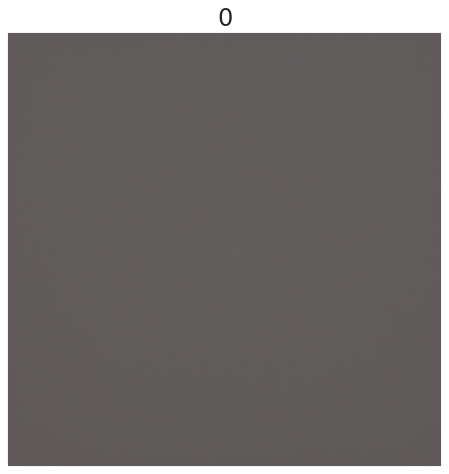

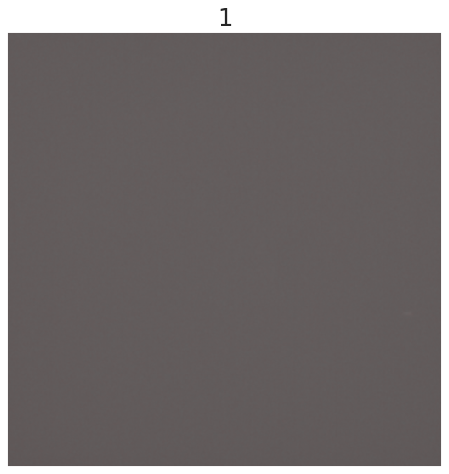

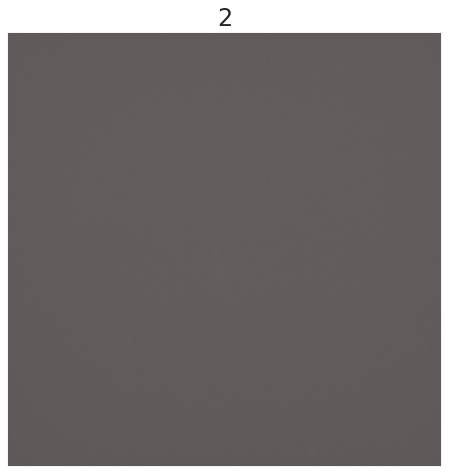

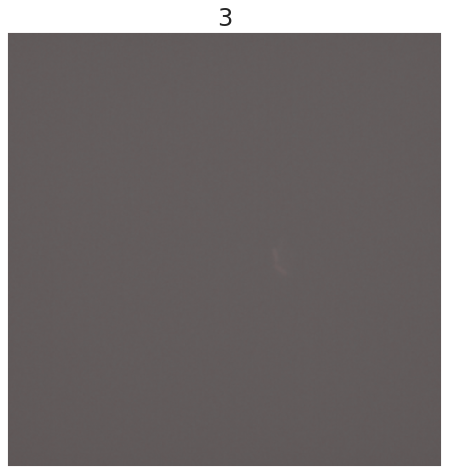

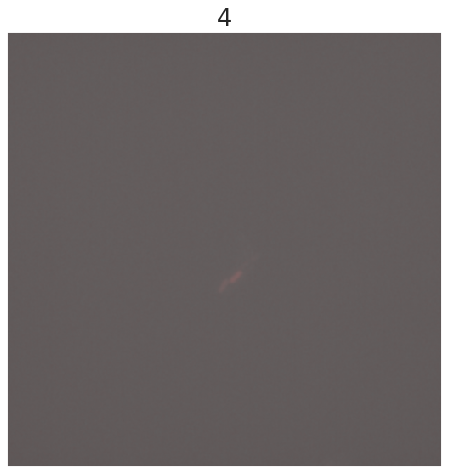

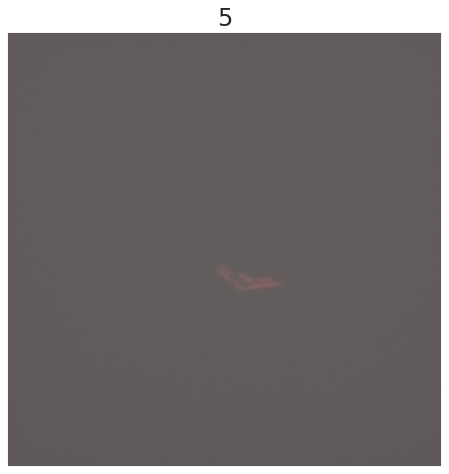

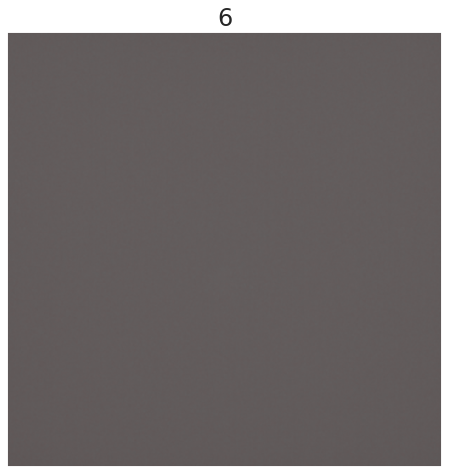

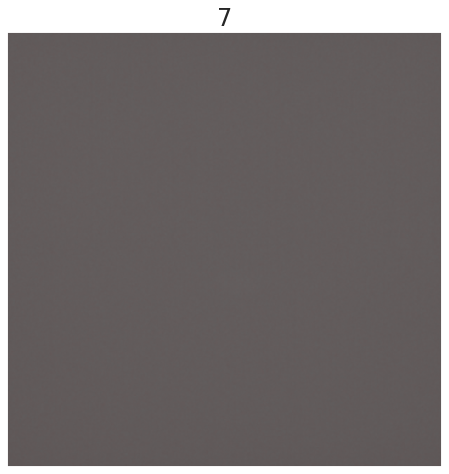

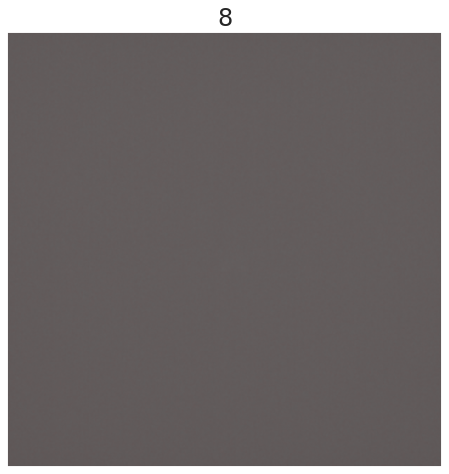

In [51]:

scale = 4
for pad in np.arange(n_pos):
    img = animate_frame(scale, pad, 20)
    fig, ax = plt.subplots(1,1,figsize=(20,8))
    ax.imshow(img)
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    _ = ax.set_title(pad)
    print(pad)
